In [2]:
import subprocess
from pymongo import MongoClient
from nltk.corpus import stopwords
from string import printable
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from sys import argv
import pickle
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from dateutil import parser
import datetime
from bs4 import BeautifulSoup
import requests
from unidecode import unidecode
import re

In [3]:
import os
import re
import operator
import matplotlib.pyplot as plt
import warnings
import gensim
warnings.filterwarnings('ignore')  # Let's not pay heed to them right now

import nltk
nltk.download('stopwords') # Let's make sure the 'stopword' package is downloaded & updated
nltk.download('wordnet') # Let's also download wordnet, which will be used for lemmatization

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from pprint import pprint

import numpy as np
import pandas as pd

%matplotlib inline

[nltk_data] Downloading package stopwords to /home/ian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
def get_df(db_name):
    url_names = ['wsj', 'cnn', 'abc', 'fox', 'nyt', 'reuters', 'wapo', 'huffpo', 'esquire', 'rollingstone', 'cbs', '538', 'washtimes']
    client = MongoClient()
    db = client[db_name]

    collection_names = db.collection_names()
    my_collection_names = [name for name in collection_names]

    df = pd.DataFrame(columns=['article_text', 'author', 'date_published', 'headline', 'url', 'source'])
    for collection_name in my_collection_names:
        if collection_name != 'system.indexes':
            site = [name for name in url_names if collection_name.startswith(name)]
            if len(site) != 0:
                site = site[0]
                print('Working on '+collection_name)
                for article in db[collection_name].find():
                    # remove article that just have videos
                    # remove powerpost articles from wapo becaue they are 4000+ words
                    if 'video' not in article['url'] and 'powerpost' not in article['url']:
                        try:
                            url = article['url']
                            source = site
                            headline = article['headline']
                            date_published = article['date_published']
                            author = article['author']
                            article_text = article['article_text']
                            # df.append(pd.Series([article_text, author, date_published, headline, url, processed_text, source]), ignore_index=True)
                            df.loc[-1] = [article_text, author, date_published, headline, url, source]  # adding a row
                            df.index = df.index + 1  # shifting index
                            df = df.sort()  # sorting by index
                        except:
                            print('Problem with article in '+site)
    return df
              

In [10]:
df = get_df('wsj_articles')
df.info()

Working on wsj_20170507_20170513
Working on wsj_20170430_20170506
Working on wsj_20170423_20170429
Working on wsj_20170416_20170422
Working on wsj_20170409_20170415
Working on wsj_20170402_20170408
Working on wsj_20170326_20170401
Working on wsj_20170319_20170325
Working on wsj_20170312_20170318
Working on wsj_20170305_20170311
Working on wsj_20170226_20170304
Working on wsj_20170219_20170225
Working on wsj_20170212_20170218
Working on wsj_20170205_20170211
Working on wsj_20170129_20170204
Working on wsj_20170122_20170128
Working on wsj_20170115_20170121
Working on wsj_20170108_20170114
Working on wsj_20170101_20170107
Working on wsj_20161225_20161231
Working on wsj_20161218_20161224
Working on wsj_20161211_20161217
Working on wsj_20161204_20161210
Working on wsj_20161127_20161203
Working on wsj_20161120_20161126
Working on wsj_20161113_20161119
Working on wsj_20161106_20161112
Working on wsj_20161030_20161105
Working on wsj_20161023_20161029
Working on wsj_20161016_20161022
Working on

In [5]:
def parse_str(x):
    if isinstance(x, str):
        return unidecode(x)
    else:
        return str(x)
def fix_cnn(df):
    for i in range(df.shape[0]):
        if df['source'][i] == 'cnn':
            url = df['url'][i]
            try:
                result = requests.get(url)
                soup = BeautifulSoup(result.content, 'html.parser')

                tag1 = soup.find('div', attrs={'class': 'el__leafmedia el__leafmedia--sourced-paragraph'}).text
                tag2 = soup.find_all('div', attrs={'class': 'zn-body__paragraph speakable'})
                tag3 = soup.find_all('div', attrs={'class': 'zn-body__paragraph'})
                new_article_text = tag1+' /n '+parse_str(' \n '.join([line.text for line in tag2]))+parse_str(' \n '.join([line.text for line in tag3]))
                df['article_text'][i] = new_article_text
            except:
                print('Problem with article!')
                print(url)
    return df

In [6]:
df = fix_cnn(df)
df.head()

Problem with article!
http://rss.cnn.com/~r/rss/cnn_allpolitics/~3/UjkGiWVhJjA/index.html
Problem with article!
http://rss.cnn.com/~r/rss/cnn_allpolitics/~3/OeoLXr1T8S8/
Problem with article!
http://rss.cnn.com/~r/rss/cnn_allpolitics/~3/w3rur2F8K6M/
Problem with article!
http://rss.cnn.com/~r/rss/cnn_allpolitics/~3/MxJJ3eGEgJU/
Problem with article!
http://rss.cnn.com/~r/rss/cnn_allpolitics/~3/-eW2vflWQys/
Problem with article!
http://rss.cnn.com/~r/rss/cnn_allpolitics/~3/VZZt8iBfcso/index.html
Problem with article!
http://rss.cnn.com/~r/rss/cnn_allpolitics/~3/UjkGiWVhJjA/index.html
Problem with article!
http://rss.cnn.com/~r/rss/cnn_allpolitics/~3/fRdP_H4ajwQ/index.html
Problem with article!
http://rss.cnn.com/~r/rss/cnn_allpolitics/~3/QyTx2TrVRRA/index.html
Problem with article!
http://rss.cnn.com/~r/rss/cnn_allpolitics/~3/QyTx2TrVRRA/index.html
Problem with article!
http://rss.cnn.com/~r/rss/cnn_allpolitics/~3/OeoLXr1T8S8/
Problem with article!
http://rss.cnn.com/~r/rss/cnn_allpolit

,article_text,author,date_published,headline,url,source
0,In his first public appearance since having be...,"[Abc News, More Veronica]",2017-06-08 14:26:51.722,Live updates: Former FBI Director James Comey ...,http://abcnews.go.com/Politics/live-updates-fb...,abc
1,Former FBI Director James Comey has begun test...,"[Abc News, Morgan Winsor, More Riley, More Mor...",2017-06-08 14:26:51.058,James Comey begins testimony before Senate pan...,http://abcnews.go.com/Politics/james-comey-beg...,abc
2,WHAT YOU NEED TO KNOW TODAY\n\nToday's the big...,"[Abc News, More Veronica]",2017-06-08 12:26:05.244,The Note: Comey goes under the microscope,http://abcnews.go.com/Politics/note-comey-micr...,abc
3,Former FBI Director James Comey will testify b...,"[Abc News, More Riley]",2017-06-08 11:25:47.129,Comey to testify before Senate panel in 1st pu...,http://abcnews.go.com/Politics/comey-testify-s...,abc
4,What: Former FBI Director James Comey testifie...,[Abc News],2017-06-08 11:25:45.922,Viewer's guide to former FBI Director James Co...,http://abcnews.go.com/Politics/viewers-guide-f...,abc


In [10]:
def parse_str(x):
    if isinstance(x, str):
        return unidecode(x)
    else:
        return str(x)
def fix_huffpo(df):
    for i in range(df.shape[0]):
        if df['source'][i] == 'huffpo':
            url = df['url'][i]
            try:
                result = requests.get(url)
                soup = BeautifulSoup(result.content, 'html.parser')

                tag = soup.find_all('div', attrs={'class': 'content-list-component bn-content-list-text text'})
                new_article_text = parse_str(' \n '.join([line.text for line in tag]))
                df['article_text'][i] = new_article_text
            except:
                print('Problem with article!')
                print(url)
    return df

In [11]:
df = fix_huffpo(df)
df[df['source'] == 'huffpo'].head()

,article_text,author,date_published,headline,url,processed_text,processed_quote,source,sentiment_of_words,probability_of_topic,sentiment,processed_tweet
219,,"['Kate Sheppard', 'Akbar Shahid Ahmed', 'Nick ...",2017-06-01 00:00:00.000,Trump's Not Just Ruining The Planet. He's Losi...,http://www.huffingtonpost.com/2017/06/01/trump...,washington environmental implication united st...,punishes united state negotiate way back paris...,huffpo,"{'environmental': [0.0, 0.0625, 0.9375, -0.003...","[0.014832362764803264, 0.059127397003156119, 0...","{19: (7.9578126118395973, 6.47320569921333, 20...",deeply disappointed united state federal gover...
220,,"['Sara Boboltz', 'Entertainment Editor']",2017-06-01 00:00:00.000,Leonardo DiCaprio Calls For Action After Trump...,http://www.huffingtonpost.com/2017/06/01/leona...,climate change activist leonardo dicaprio offe...,america first hoax flood important ever take a...,huffpo,"{'trump': [0.017857142857142856, 0.0, 0.982142...","[0.015001550910337471, 0.052853741983540384, 0...","{19: (7.0028258003264874, 4.8252651363870971, ...",take action supporting organization front line...
221,,"['David Moye', 'Reporter']",2017-06-01 00:00:00.000,Twitter Mercilessly Mocks Sean Hannity For Whi...,http://www.huffingtonpost.com/2017/06/01/sean-...,sean hannity proved seth rich handle truth sho...,investigation hundred miniature sean hannitys ...,huffpo,"{'sean': [0, 0, 0, 0], 'seth': [0.0, 0.0, 1.0,...","[0.014391083614490256, 0.048882591286194002, 0...","{19: (9.9971567643908479, 2.6601630578775448, ...",wrong left think sort thing funny http co saxo...
222,,"['Antonia Blumberg', 'Reporter']",2017-06-01 00:00:00.000,Vatican Sees U.S. Climate Accord Withdrawal As...,http://www.huffingtonpost.com/2017/06/01/vatic...,barely week meeting pope francis promising rea...,really pull would huge slap face u disaster ev...,huffpo,"{'barely': [0.0625, 0.1875, 0.75, -0.03125], '...","[0.021256505436694072, 0.062841562766928996, 0...","{19: (7.527172569051559, 4.0286458228956619, 2...",climate change represents one principal challe...
223,,[],2017-06-01 00:00:00.000,EPA Starts Offering Buyouts In Bid To Cut Staff,http://www.huffingtonpost.com/2017/06/01/epa-b...,washington june 1 reuters u environmental prot...,early out buy out help u realign workforce mee...,huffpo,"{'u': [0.0, 0.0, 1.0, 0.0], 'environmental': [...","[0.015660155134319922, 0.084063956924650837, 0...","{19: (6.0220844965182501, 6.3602707417573061, ...",NaN


In [7]:
def clean_df(df):
    # Remove duplicates by url
    df = df.drop_duplicates(subset='url')
    # Below I get rid of large articles that could throw off my algorithms
    # Remove two article types that were very long
    # any url with speech was just a transcript of speeches
    df = df[(df['source'] != 'ap') & (df['source'] != 'economist') & (df['source'] != 'vox') & (df['source'] != 'time') & (df['source'] != 'slate')]

    df[df['source'] == 'wapo'] = df[(df['source'] == 'wapo') & (df['url'].str.contains('powerpost') == False) & (df['url'].str.contains('-speech-') == False)]
    df[df['source'] == 'economist'] = df[(df['source'] == 'economist') & (df['url'].str.contains('transcript') == False)]
    df[df['source'] == 'fox'] = df[(df['source'] == 'fox') & (df['article_text'].str.contains('Want FOX News Halftime Report in your inbox every day?') == False)]
    df[df['source'] == 'esquire'] = df[(df['source'] == 'esquire') & (df['url'].str.contains('-gallery-') == False)]

    # Can't have null values in text
    df = df[pd.notnull(df['article_text'])]
    df = df.dropna(how='all')
    return df

In [8]:
df = clean_df(df)
df.head()

,article_text,author,date_published,headline,url,source
0,In his first public appearance since having be...,"[Abc News, More Veronica]",2017-06-08 14:26:51.722,Live updates: Former FBI Director James Comey ...,http://abcnews.go.com/Politics/live-updates-fb...,abc
1,Former FBI Director James Comey has begun test...,"[Abc News, Morgan Winsor, More Riley, More Mor...",2017-06-08 14:26:51.058,James Comey begins testimony before Senate pan...,http://abcnews.go.com/Politics/james-comey-beg...,abc
2,WHAT YOU NEED TO KNOW TODAY\n\nToday's the big...,"[Abc News, More Veronica]",2017-06-08 12:26:05.244,The Note: Comey goes under the microscope,http://abcnews.go.com/Politics/note-comey-micr...,abc
3,Former FBI Director James Comey will testify b...,"[Abc News, More Riley]",2017-06-08 11:25:47.129,Comey to testify before Senate panel in 1st pu...,http://abcnews.go.com/Politics/comey-testify-s...,abc
4,What: Former FBI Director James Comey testifie...,[Abc News],2017-06-08 11:25:45.922,Viewer's guide to former FBI Director James Co...,http://abcnews.go.com/Politics/viewers-guide-f...,abc


In [9]:
# df = pd.read_csv('../data/rss_feeds_new.csv')
# df = df[pd.notnull(df['processed_text'])]
# text = df['processed_text'].values.tolist()
if False:
    df = pd.read_csv('../data/rss_feeds_new.csv')
df = df[pd.notnull(df['article_text'])]

In [12]:
def get_article_length_hist(df):
    site_article_length = {source: [] for source in df['source'].unique()}
    for source in df['source'].unique():
        new_df = df[df['source'] == source]
        for article in new_df['article_text']:
            site_article_length[source].append(len(article.split()))


    for i, source in enumerate(site_article_length.keys()):
        plt.subplot(4,3,i+1)
        plt.hist(site_article_length[source], normed=True, bins=100)
        plt.title('Article Length '+source)
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

Populating the interactive namespace from numpy and matplotlib


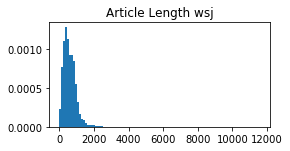

In [13]:
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

get_article_length_hist(df)

In [11]:
df.to_csv('wsj_good.csv')